In [25]:
import numpy as np
import time as time
import matplotlib.pyplot as plt
import math
import cmath
import gmpy2 as gp
from gmpy2 import mpc
import scipy as sp
from scipy import stats

gp.get_context().precision=500

In [4]:
#This function provides a list of the admissible colors for the given level set r:
def colors(r):
    I = [i for i in range((r-3)//2+1)]
    return I

#Primitive root of unity for which we are computing all of our invariants, as a function of the level set r:
def A(r):
    B = gp.exp(np.pi*1j/(r))
    return B
################################################################################################

################################################################
#Supporting functions for quantum integers and factorials
################################################################

def Q(n,A):
    z = (-A)**(n) - (-A)**(-n)
    return z.imag*1j

def Qp(n,A):
    z = (-A)**(n) + (-A)**(-n)
    return z.real
def f1(N,A):
    if N==0:
        return 1
    elif N>0:
        return np.prod([Q(i,A) for i in range(1,N+1)])
    else: 
        return 0
def f1p(N,A):
    if N==0:
        return 2
    elif N>0:
        return np.prod([Qp(i,A) for i in range(1,N+1)])
    else: 
        return 0
def f2(N,A):
    if N==0:
        return 1
    else:
        temp=1
        for i in range(N,0,-2):
            temp=temp*Q(i,A)
            continue
        return temp
def mu(n,A):
    return (-A)**(n*(n+2))
def lamb(n,A):
    return -Q(2*n+2,A)

################################################################################################

################################################################
#Functions used to construct the representations for C_R and C_L
################################################################
def R(c,n,m,A):
    x = f1(m,A)*f2(2*c+2*n+1,A)*f1p(2*c+n+1,A)
    y = f1(n,A)*f2(2*c+2*m+1,A)*f1p(2*c+m+1,A)
    return x/y

def Mminus(N,n,m,A):
    x = Q(m,A)*((-A)**(-2*N+2*m))
    y = Q(n+1,A)
    return x/y
def Mplus(N,n,m,A):
    x = ((-A)**(-2*N+2*m+2))*Q(-2*N+2*m+2,A)*Qp(-2*N+m+1,A)
    y = Q(n+1,A)
    return x/y
def Mmid1(c,N,n,m,A):
    x = (A-A**(-1))*(lamb(c+m,A))**(2)+A*(Q(m+1,A)**(2))*R(c,m+1,m,A)-A**(-1)*(Q(m,A)**2)*R(c,m,m-1,A)-Q(2,A)*lamb(c+n,A)
    y = Q(2,A)*Q(n+1,A)
    return x/y

def Mmid(c,N,n,m,A):
    x = (A-A**(-1))*(Qp(2*N-2*m-1,A))**(2)+A*(Q(m+1,A)**(2))*R(c,m+1,m,A)-A**(-1)*(Q(m,A)**2)*R(c,m,m-1,A)+Q(2,A)*Qp(2*N-2*n-1,A)
    y = Q(2,A)*Q(n+1,A)
    return x/y

def makeM(N,c,n,A):
    bigM = np.zeros(shape=(N,N),dtype=mpc)
    bigM[0,0] = Mmid(c,N,n,0,A)
    bigM[0,1] = Mplus(N,n,0,A)
    bigM[N-1,N-2] = Mminus(N,n,N-1,A)
    bigM[N-1,N-1] = Mmid(c,N,n,N-1,A)
    for m in range(1,N-1):
        bigM[m,m] = Mmid(c,N,n,m,A)
        bigM[m,m-1] = Mminus(N,n,m,A)
        bigM[m,m+1] = Mplus(N,n,m,A)
    return bigM

################################################################################################

################################################################
#Build libraries for R and L representations
################################################################

def makeRepR(N,c,A):
    S = np.zeros(shape=(N,N),dtype = mpc)
    S[0,0] = 1
    for n in range(1,N):
        M = makeM(N,c,n-1,A)
        S[:,n] = M.dot(S[:,n-1])
    return S


Time for R reps at r = 11: 0.171875 seconds
-------------------------------------------------------------------------------------
Time to build R Library: 0.1875 seconds
-------------------------------------------------------------------------------------
Time for L reps at r = 11: 0.0625 seconds
-------------------------------------------------------------------------------------
Time to build L Library: 0.0625 seconds
-------------------------------------------------------------------------------------
Middle color values:
(11, mpfr('1.647218562018233224785710888773982314238798098934839092884702599263700822870094319867362479063788897787870704151903817188900924248186668381258367001188',500))
-------------------------------------------------------------------------------------
Time to compute QV Library: 0.015625 seconds
-------------------------------------------------------------------------------------
Library:
{'RL': [[11, mpfr('2.406606471804026082992845620174593974681197329750853

{'RL': [[11,
   mpfr('2.4066064718040260829928456201745939746811973297508532697064215310317613145830003292944148814886681432071257967684580498797328685309575653114935318971543',500)]]}

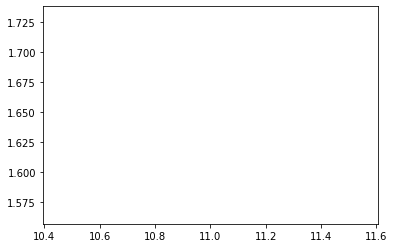

In [3]:
#####################################################################################

#Here are some test arrays of level sets that will come in handy:
test = [11]
test1  = [3,7,11,15,19,23,27,31,35,39,43,47,51,55,59,63,67,71,75,79,83,87,91,95,99,103,107,111]

test1 = [61,63,65,67,69,71,73,75,77,79,81,83,85,87,89,91]
test1 = [3,5,7,9,11,13,15,17,19,23,29,35,41,51,61,71,81]
test1 = [3,5,7,9,11,13,15,17,19,21]
test11 = [11,13,15,17,19,21,23,25,31,41,51,61,71,81,91,101,111]

#Chen-Yang Test set for the figure eight knot complement:
CYtest = [11,13,15,17,19,21,23,25,31,41,51,61,71,81,91,101,111,201,301,401,501,701,1001]

##################################################################################################

def libR(array):
    lib = {}
    #np.empty(dtype = object)
    for r in array:
        ts = time.process_time()
        I = colors(r)
        repsr = [makeRepR((r-1)//2-c,c,A(r)) for c in I]
        lib[r] = repsr
        print('Time for R reps at r = %s: %s seconds' %(r,time.process_time()-ts))
    return lib

time_start = time.process_time()

Rlib = libR(test)

print('-------------------------------------------------------------------------------------')

time_elapsed = (time.process_time() - time_start)
print('Time to build R Library: %s seconds' % time_elapsed)

print('-------------------------------------------------------------------------------------')

#Once we have the R rep library, we can construct the corresponding library of L reps using these two functions:

def makeRepL(N,r,c,A):
    repR = Rlib[r][c]
    #S = (b_{n,m})
    S = np.linalg.inv(np.array([[repR[m,n]/R(c,n,m,A) for m in range(N)] for n in range(N)],dtype=complex)).astype(mpc)
    return S

def libL(array):
    lib = {}
    for r in array:
        ts = time.process_time()
        I = colors(r)
        repsr = [makeRepL((r-1)//2-c,r,c,A(r)) for c in I]
        lib[r] = repsr
        print('Time for L reps at r = %s: %s seconds' %(r,time.process_time()-ts))
    return lib

time_start = time.process_time()

Llib = libL(test)

print('-------------------------------------------------------------------------------------')

time_elapsed = (time.process_time() - time_start)
print('Time to build L Library: %s seconds' % time_elapsed)

print('-------------------------------------------------------------------------------------')

################################################################################################

#Define representations of C_R and C_L:

def genRep(r,c,string):
    #r >= 3 is odd TV parameter
    #c is color from list of colors, N = (r-1)/2 - c
    #k is choice of primitive 2r root of unity 
    #string is the string of L's and R's 
    N = (r-1)//2-c
    if 'R' in string:
        repR = Rlib[r][c]
    if 'L' in string:
        repL = Llib[r][c]
    rho = np.zeros(shape=(N,N), dtype=mpc)
    first = string[0]
    if first == 'L':
        rho = repL
    else: 
        rho = repR
    for char in string[1:]:
        if char == 'L':
            rho = rho.dot(repL)
        else:
            rho = rho.dot(repR)
    return rho



def cc(r):
    if r % 4 == 3:
        return (r-3)//4
    
def midRep(r):
    return (2*np.pi)/(r)*gp.log(abs(np.trace(genRep(r,cc(r),'RL')))**2)

x = np.zeros(shape = (len(test),))
y = np.zeros(shape = (len(test),))
i=0
print('Middle color values:')
for r in test:
    if r%4==3:
        x[i] = r
        #print(x)
        y[i] = midRep(r)
        print((r,midRep(r)))
        i=i+1
plt.plot(x,y)

print('-------------------------------------------------------------------------------------')

################################################################################################

################################################################
#Computing the Turaev-Viro
################################################################

def TV(r,string):
    I = colors(r)
    traces = [abs(np.trace(genRep(r,c,string)))**2 for c in I]
    TV = sum(traces)
    return TV

#This function computes the logarithm of TV_r, as the Volume Conjecture requires
def QV(r,string):
    return ((2*np.pi)/(r-2))*gp.log(TV(r,string))

################################################################################################

################################################################
#Given a list of level sets (subset of the representations library created above) and a list of monodromies 
#(as strings in R,L), this function constructs a library of QV_r values keyed by the string representing the monodromy
################################

def TVLib(array,strings):
    lib = {}
    time_start = time.process_time()
    for stg in strings:
        TVallr = [[r,TV(r,stg)] for r in array]
        lib[stg] = TVallr
    time_elapsed = (time.process_time() - time_start)
    print('Time to compute QV Library: %s seconds' % time_elapsed)
    #print(lib)
    return lib

def QVLib(array,strings):
    lib = {}
    time_start = time.process_time()
    for stg in strings:
        QVallr = [[r,QV(r,stg)] for r in array]
        lib[stg] = QVallr
    time_elapsed = (time.process_time() - time_start)
    print('Time to compute QV Library: %s seconds' % time_elapsed)
    print('-------------------------------------------------------------------------------------')
    print('Library:')
    print(lib)
    return lib


################################################################################################

QVLib(test,['RL'])


#TVLib(test,['RL','LR'])

In [ ]:
test = np.array(range(213))
test1 = np.array([3,5,7,9,11,13,15,17,19,23,29,35,41,51,61,71,81,91,101,111,131,151,171,191,211])
test1 = np.array([3,5,7,9,11,13,15,17,19,23,29,35,41,51,61,71,81,91,101,111,211,311])
test1 = np.array([29,35,41,51,61,71,81,91,101,111411,511,611,711,811,911,1011,1111])

#Chen-Yang Test set for the figure eight knot complement:
CYtest = np.array([11,13,15,17,19,21,23,25,31,41,51,61,71,81,91,101,111,201,301,401,501,701,1001])
############################################################################################
def cc(r):
    return (r-3)//4

def libRmid(array):
    lib = {}
    arr3 = array[array %4 ==3]
    #np.empty(dtype = object)
    for r in arr3:
        repsr = makeRepR((r-1)//2-cc(r),cc(r),A(r))
        lib[r] = repsr
    #print(lib)
    return lib

time_start = time.process_time()

Rlibmid = libRmid(test)

time_elapsed = (time.process_time() - time_start)
print('Time to build R Library: %s seconds' % time_elapsed)

#Once we have the R rep library, we can construct the corresponding library of L reps using these two functions:

def makeRepLmid(N,r,A):
    repR = Rlibmid[r]
    c=cc(r)
    S = np.linalg.inv(np.array([[repR[m,n]/R(c,n,m,A) for m in range(N)] for n in range(N)],dtype=complex)).astype(mpc)
    return S

def libLmid(array):
    lib = {}
    arr3 = array[array %4 == 3]
    for r in arr3:
        repsr = makeRepLmid((r-1)//2-cc(r),r,A(r))
        lib[r] = repsr
    #print(lib)
    return lib

time_start = time.process_time()

Llibmid = libLmid(test)

time_elapsed = (time.process_time() - time_start)
print('Time to build L Library: %s seconds' % time_elapsed)

def midRep(r,string):
    #r >= 3 is odd TV parameter
    #c is color from list of colors, N = (r-1)/2 - c
    #k is choice of primitive 2r root of unity 
    #string is the string of L's and R's 
    N = (r-1)//2-cc(r)
    if 'R' in string:
        repR = Rlibmid[r]
    if 'L' in string:
        repL = Llibmid[r]
    rho = np.zeros(shape=(N,N), dtype=mpc)
    first = string[0]
    if first == 'L':
        rho = repL
    else: 
        rho = repR
    for char in string[1:]:
        if char == 'L':
            rho = rho.dot(repL)
        else:
            rho = rho.dot(repR)
    return rho

In [23]:
def midRepVals(array, string):
    arr3 = array[array %4 ==3]
    x = np.zeros(shape = (len(arr3),))
    y = np.zeros(shape = (len(arr3),))
    i=0
    for r in arr3:
        valr = (2*np.pi)/(r)*gp.log(abs(np.trace(midRep(r,string)))**2)
        print(r,valr)
        x[i] = r
        y[i] = valr
        i=i+1
    return x,y

def midRepVal(r, string):
    return (2*np.pi)/(r)*gp.log(abs(np.trace(midRep(r,string)))**2)

def genRLn(n):
    x = ''
    for i in range(n):
        x = x+ 'RL'
    return x

3 0.0
7 8.8323383822598245542586659712512740104017400661269487220644392536876273944559259269247296105512104610129051151550449660143087735693398657770397932350738
11 12.090893383117953536320564505247645479831799184077241495502989269734377156145952803906220960495897611340736375391934342609656887818109128690635607975296
15 14.076808473991027245389307194908682332669402049998634047170425629496699824927781188245921800215107766418312329556589384526331777114071955120371736530579
19 15.321495240855676113587042182349180749120150301233204792141986647446217815034232282999568658024181299544474978616699126893256685954675923250981695267414
23 16.156189031123450905246858317563523209313586015575136363462792477121497315488544066906772712517785642246460638990738845247255490133274063118240577599174
27 16.752047265731095894216259197367695242682177741781038322403000425802190331596933248005616019043308467206187382150552751492230068512486509843445927905059
31 17.19830233453777581226777059360520166866055695240

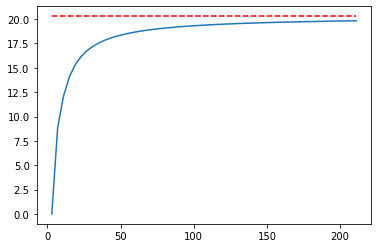

In [21]:
x,y = midRepVals(test,'RLRLRLRLRLRLRLRLRLRL')
vol = np.array([20.298832128 for i in range(len(x))])
plt.plot(x,y)
plt.plot(x,vol,'r--')
plt.show()

AttributeError: 'float' object has no attribute 'shape'

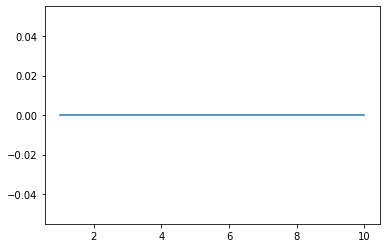

In [26]:
mfds = [genRLn(n) for n in range(1,11)]
x = range(1,len(mfds)+1)
for r in test[test%4==3]:
    y = [midRepVal(r,word) for word in mfds]
    plt.plot(x,y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    print("For r=%s, slope = %s and r_value = %s" %(r,slope,r_value))
plt.show()

3 0.0
7 1.453367033079135051930321211381106584559137696123398603547188470675920000091489748315738963006113245635927901774978036854160276233364504182543065650022
11 1.7135972755265013333013745797080372229961241355792341374231643156245152545283094909128181676808211584724802053334561003771005636539964538885818568862108
15 1.8873035803232887562330856264275097161651659412054264463668895252194487671948092377836660023318862181341706325722122342008824025865769011506468105582565
19 2.029190263699695103608153758564128458984315875996156797247154385952656423348384663188970212642560464271621179718381370544206815138576153089237089182644
23 2.1362396705882940035017467556261456479464405212926372542855883334660227034282322334399265576565563282812568397323509152693116192224853122777694628527996
27 2.2141951608475245365873959474458846677638311127943355252208114316754467434056860554600101083777978429388612389556609416589856407069910450887400682340435
31 2.27184714806653410334773307656943539005758934553846

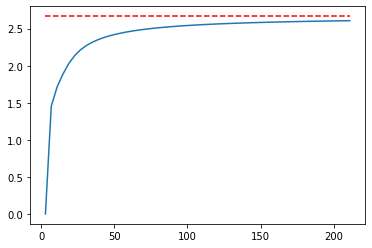

In [19]:
x,y = midRepVals(test,'RLL')
vol = np.array([2.66674478345 for i in range(len(x))])
plt.plot(x,y)
plt.plot(x,vol,'r--')
plt.show()